<a href="https://colab.research.google.com/github/Renni-W/Crude-Oil-Deep-Learning-Predictions/blob/main/Deep_Belief.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 pip install tensorflow


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt

df = pd.read_csv('merged_data1.csv')
features = df[['CRD_HIGH', 'CRD_LOW', 'FX_Price', 'FX_Open', 'G_USD']]
target = df['CRD_CLOSE']

# Scale your data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)
scaled_target = scaler.fit_transform(target.values.reshape(-1, 1))

In [ ]:
# Define the model
def create_autoencoder(input_dim, output_dim):
    # This will represent one layer of an RBM (but as an autoencoder)
    autoencoder = Sequential()
    autoencoder.add(Dense(output_dim, input_dim=input_dim, activation='relu', name='encoder'))
    autoencoder.add(Dense(input_dim, activation='sigmoid', name='decoder'))

    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

# Function to pre-train our deep network one layer at a time
def pretrain_autoencoders(layers, epochs=50):
    global scaled_features
    encoders = []

    input_dim = scaled_features.shape[1]

    for output_dim in layers:
        autoencoder = create_autoencoder(input_dim, output_dim)
        autoencoder.fit(scaled_features, scaled_features, epochs=epochs, batch_size=256, verbose=0)

        # Retrieve the encoder layer
        encoder = autoencoder.get_layer('encoder')

        # Store the encoder for later use
        encoders.append(encoder)

        # Update the input for the next autoencoder
        encoder_model = Sequential([encoder])
        scaled_features = encoder_model.predict(scaled_features)

        # Reshape the output for the next autoencoder input
        input_dim = output_dim

    return encoders

# Pre-train autoencoders
# The layers list contains the sizes of the hidden layers for the DBN
encoders = pretrain_autoencoders(layers=[128, 64])

251/251 [==============================] - 0s 1ms/step


Use this instead of above

In [ ]:
def create_autoencoder(input_dim, output_dim, layer_number):
    # This will represent one layer of an RBM (but as an autoencoder)
    autoencoder = Sequential()
    encoder_layer_name = f'encoder_{layer_number}'
    decoder_layer_name = f'decoder_{layer_number}'

    autoencoder.add(Dense(output_dim, input_dim=input_dim, activation='relu', name=encoder_layer_name))
    autoencoder.add(Dense(input_dim, activation='sigmoid', name=decoder_layer_name))

    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

def pretrain_autoencoders(layers, epochs=50):
    global scaled_features
    encoders = []

    input_dim = scaled_features.shape[1]

    for i, output_dim in enumerate(layers):
        autoencoder = create_autoencoder(input_dim, output_dim, i)
        autoencoder.fit(scaled_features, scaled_features, epochs=epochs, batch_size=256, verbose=0)

        # Retrieve the encoder layer
        encoder = autoencoder.get_layer(f'encoder_{i}')

        # Store the encoder for later use
        encoders.append(encoder)

        # Update the input for the next autoencoder
        encoder_model = Sequential([encoder])
        scaled_features = encoder_model.predict(scaled_features)

        # Reshape the output for the next autoencoder input
        input_dim = output_dim

    return encoders

# Pre-train autoencoders
# The layers list contains the sizes of the hidden layers for the DBN
encoders = pretrain_autoencoders(layers=[128, 64])

251/251 [==============================] - 0s 1ms/step


In [ ]:
# Define the deep belief network
dbn = Sequential()

# Add the pre-trained encoder layers
for encoder1 in encoders:
    dbn.add(encoder1)

# Add a regression layer for prediction
dbn.add(Dense(1, activation='linear'))

# Compile the model
dbn.compile(optimizer='adam', loss='mse')

# Now, we train the DBN with the fine-tuning process
# We'll use the scaled_features and scaled_target that we previously computed

# Split your data into train and test sets
from sklearn.model_selection import train_test_split

#X_train, X_test, y_train, y_test = train_test_split(scaled_features, scaled_target, test_size=0.3, random_state=42)

train_size = int(len(scaled_features) * 0.70)
test_size = len(scaled_features) - train_size
X_train, X_test = scaled_features[0:train_size,:], scaled_features[train_size:len(scaled_features),:]
y_train, y_test = scaled_target[0:train_size], scaled_target[train_size:len(scaled_target)]

# Train the model
history = dbn.fit(X_train, y_train, epochs=50, batch_size=256, validation_data=(X_test, y_test), verbose=0)



In [ ]:
# After training, evaluate the model's performance
mse_test = dbn.evaluate(X_test, y_test)
print(f'Test MSE: {mse_test}')

# Make predictions
predictions = dbn.predict(X_test)
train_predictions = dbn.predict(X_train)
# Inverse transform the predictions to original scale if needed
predictions_original_scale = scaler.inverse_transform(predictions)
y_test_original_scale = scaler.inverse_transform(y_test)

# Calculate root mean squared error
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_test_original_scale, predictions_original_scale))
print(f'Test RMSE: {rmse}')

76/76 [==============================] - 0s 1ms/step - loss: 0.0310
Test MSE: 0.03096351958811283
176/176 [==============================] - 0s 1ms/step
Test RMSE: 23.77104585805706


In [ ]:
#printing the prediction values
y_test_original_scale
aa = pd.DataFrame(list(zip(predictions_original_scale, y_test_original_scale)), columns=["Predict","Y"])
aa

,Predict,Y
0,[103.06378],[109.1]
1,[103.05637],[109.4]
2,[102.18122],[108.525]
3,[102.67426],[108.825]
4,[104.82015],[111.305]
...,...,...
2404,[49.463352],[92.395]
2405,[48.96361],[92.02]
2406,[49.77268],[93.6]
2407,[49.3561],[93.385]


In [ ]:
k = df.iloc[-2393:len(df)-1,:2]

k.reset_index(drop=True, inplace=True)
aa = aa.iloc[-2393:len(aa)-1,:2]
aa.reset_index(drop=True, inplace=True)
#aa["Predict"] = aa["Predict"].str.strip("[]")
aa["Predict"] = aa["Predict"].apply(lambda x: str(x).strip('[]'))
#aa["Predict"] = pd.to_numeric(aa["Predict"])
newcon = pd.concat([k, aa["Predict"]], axis = 1)
newcon.to_csv("DBNPredict.csv")
newcon

,Date,CRD_CLOSE,Predict
0,3/20/2014,106.050,99.49424
1,3/21/2014,105.715,99.07444
2,3/24/2014,107.285,100.19837
3,3/25/2014,106.655,99.41933
4,3/26/2014,107.020,99.682785
...,...,...,...
2387,9/8/2023,91.900,49.189648
2388,9/11/2023,92.395,49.463352
2389,9/12/2023,92.020,48.96361
2390,9/13/2023,93.600,49.77268


In [ ]:
df.tail()

,Date,CRD_CLOSE,CRD_HIGH,CRD_LOW,FX_Price,FX_Open,G_USD
8024,9/11/2023,92.395,92.40,92.39,11.35,11.485,1924.95
8025,9/12/2023,92.020,92.03,92.01,11.35,11.425,1908.55
8026,9/13/2023,93.600,93.61,93.59,11.42,11.425,1913.80
8027,9/14/2023,93.385,93.39,93.38,11.43,11.475,1901.75
8028,9/15/2023,95.105,95.11,95.10,11.48,11.475,1927.70


In [ ]:
mse = mean_squared_error(y_test_original_scale, predictions_original_scale)
mae = mean_absolute_error(y_test_original_scale, predictions_original_scale)
r2 = r2_score(y_test_original_scale, predictions_original_scale)
print([mse,mae, r2])

[636.7050427581713, 22.94931949943267, -0.35072038728952526]


In [ ]:
# # Plot the actual vs predicted values
# trainPredict_original = scaler.inverse_transform(train_predictions)
# trainY_original = scaler.inverse_transform(X_train)
# testPredict_original = scaler.inverse_transform(predictions)
# testY_original = scaler.inverse_transform(y_test)

# plt.figure(figsize=(15, 6))
# plt.plot(trainY_original, label='Actual Train')
# plt.plot(trainPredict_original, label='Predicted Train')
# plt.plot(range(len(trainY_original), len(trainY_original) + len(testY_original)), testY_original, label='Actual Test')
# plt.plot(range(len(trainPredict_original), len(trainPredict_original) + len(testPredict_original)), testPredict_original, label='Predicted Test')
# plt.title(' ')
# plt.xlabel('Time')
# plt.ylabel('Brent Crude Oil Close Price')
# plt.legend()
# plt.show()

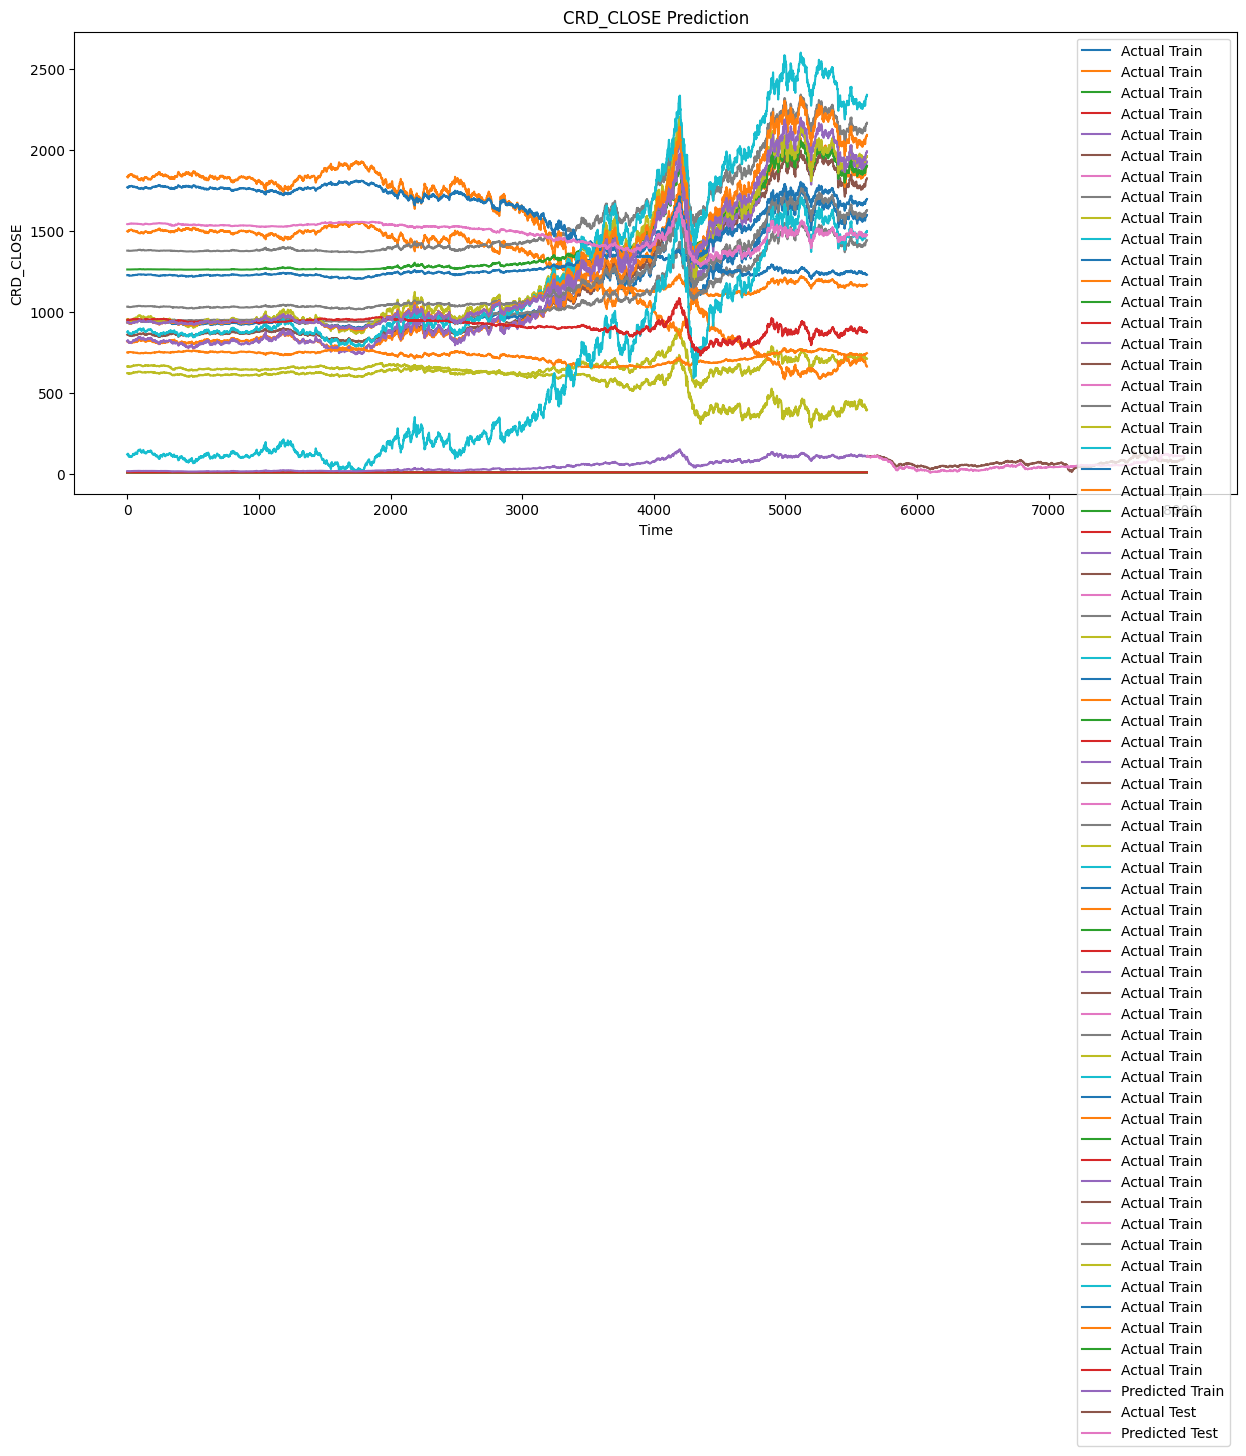

In [ ]:
# Assuming trainPredict and testPredict are your predictions
# and trainY and testY are the actual values from the training and test sets
# First, invert the scaling for each dataset
trainPredict_original = scaler.inverse_transform(train_predictions)
trainY_original = scaler.inverse_transform(X_train)
testPredict_original = scaler.inverse_transform(predictions)
testY_original = scaler.inverse_transform(y_test)

# Plot the actual vs predicted values
plt.figure(figsize=(15, 6))
plt.plot(trainY_original, label='Actual Train')
plt.plot(trainPredict_original, label='Predicted Train')
plt.plot(range(len(trainY_original), len(trainY_original) + len(testY_original)), testY_original, label='Actual Test')
plt.plot(range(len(trainPredict_original), len(trainPredict_original) + len(testPredict_original)), testPredict_original, label='Predicted Test')
plt.title('CRD_CLOSE Prediction')
plt.xlabel('Time')
plt.ylabel('CRD_CLOSE')
plt.legend()
plt.show()

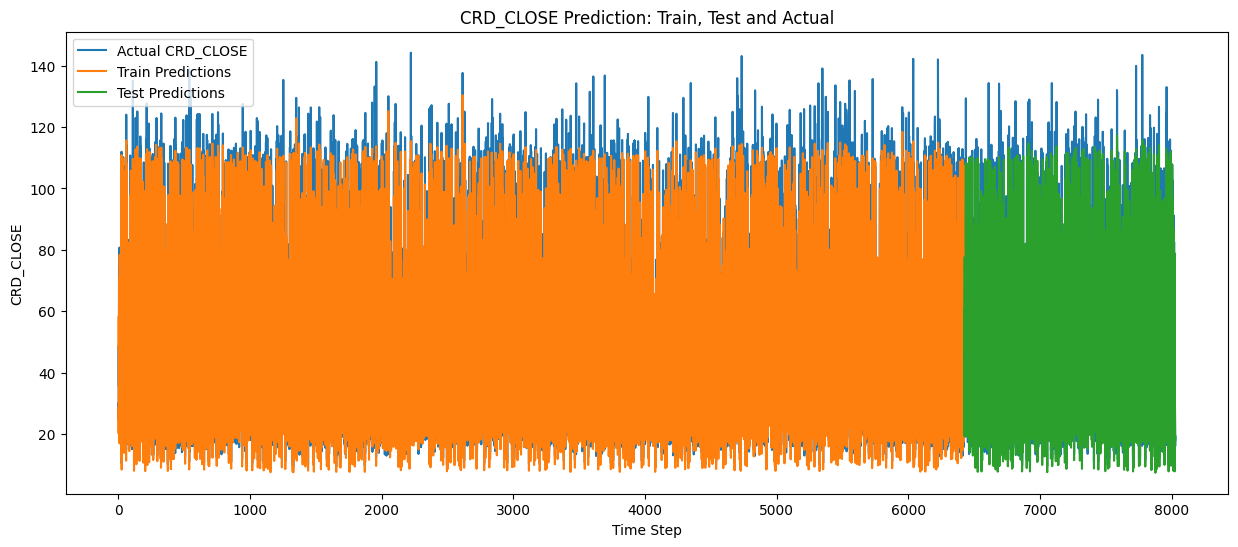

In [ ]:
# Assuming trainPredict and testPredict are your predictions
# and trainY and testY are the actual values from the training and test sets
# First, invert the scaling for each dataset
trainPredict_original = scaler.inverse_transform(train_predictions)
trainY_original = scaler.inverse_transform(y_train)
testPredict_original = scaler.inverse_transform(predictions)
testY_original = scaler.inverse_transform(y_test)

# Create a continuous sequence for predictions and actual values
total_samples = len(trainY_original) + len(testY_original)
trainPredict_plot = np.empty((total_samples, 1))
trainPredict_plot[:, :] = np.nan
trainPredict_plot[:len(trainPredict_original), :] = trainPredict_original

testPredict_plot = np.empty((total_samples, 1))
testPredict_plot[:, :] = np.nan
testPredict_plot[len(trainPredict_original):len(trainPredict_original) + len(testPredict_original), :] = testPredict_original

actualY_plot = np.vstack((trainY_original, testY_original))

plt.figure(figsize=(15, 6))
plt.plot(actualY_plot, label='Actual CRD_CLOSE')
plt.plot(trainPredict_plot, label='Train Predictions')
plt.plot(testPredict_plot, label='Test Predictions')
plt.title('CRD_CLOSE Prediction: Train, Test and Actual')
plt.xlabel('Time Step')
plt.ylabel('CRD_CLOSE')
plt.legend()
plt.show()

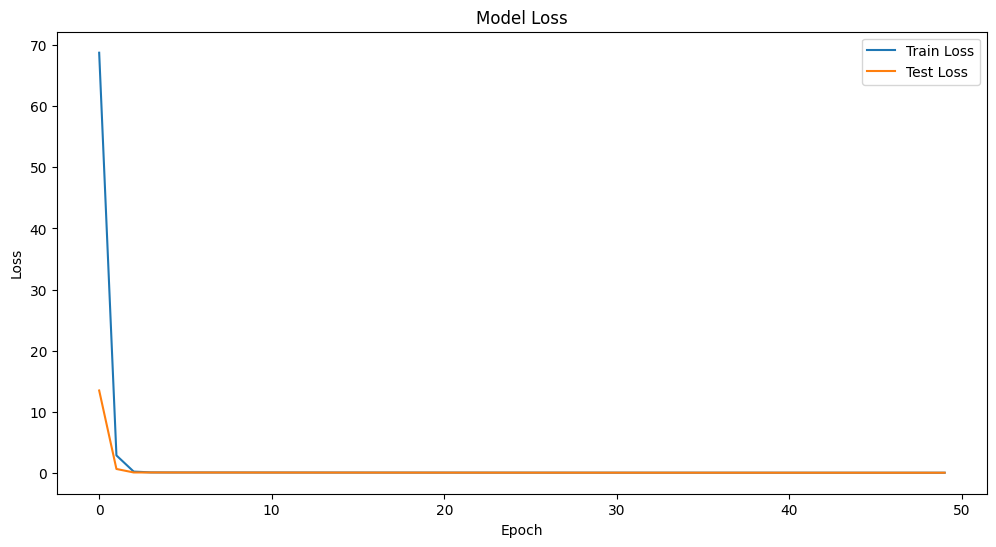

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [ ]:
trainY_original

array([[29.965],
       [24.515],
       [48.885],
       ...,
       [15.745],
       [77.02 ],
       [38.505]])

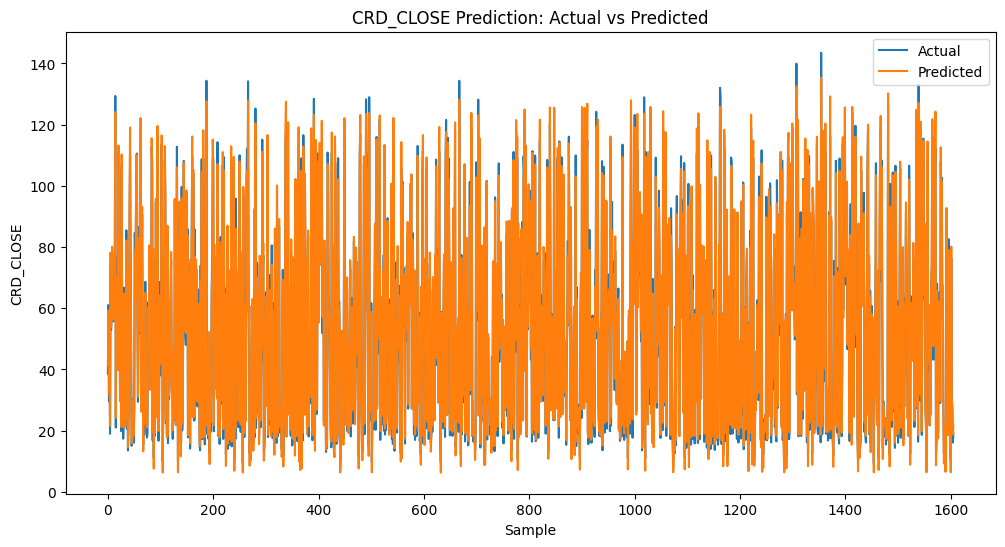

In [ ]:
# Plot actual vs predicted values
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test_original_scale, label='Actual')
plt.plot(predictions_original_scale, label='Predicted')
plt.title('CRD_CLOSE Prediction: Actual vs Predicted')
plt.xlabel('Sample')
plt.ylabel('CRD_CLOSE')
plt.legend()
plt.show()

In [ ]:
# Save the model
dbn.save('dbn_model.h5')

# Load the model (if needed later)
from tensorflow.keras.models import load_model
dbn = load_model('dbn_model.h5')